## Import Libraries

In [ ]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import warnings
warnings.filterwarnings( 'ignore')

In [ ]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Load Dataset

We used the [BIST 100](https://finance.yahoo.com/quote/XU100.IS/history?p=XU100.IS) dataset.

In [ ]:
df = pd.read_csv('XU100.IS2.csv')

We will correct some errors in the database. We think that the reason for this error is the removal of zeros from the money.

In [ ]:
# Drop rows with missing values (NaN)
df = df.dropna()

# Normalize the columns values up to index 1203 by dividing them by 100
df.loc[:1203, 'Open'] = df.loc[:1203, 'Open'] / 100
df.loc[:1203, 'High'] = df.loc[:1203, 'High'] / 100
df.loc[:1203, 'Low'] = df.loc[:1203, 'Low'] / 100
df.loc[:1203, 'Close'] = df.loc[:1203, 'Close'] / 100
df.loc[:1203, 'Adj Close'] = df.loc[:1203, 'Adj Close'] / 100

df = df.loc[df['Date'] < '2020-12-31']

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-06-30,18.570000,19.360000,18.260000,19.180000,19.180000,1.236020e+07
1,1997-07-07,19.180000,20.270000,18.940000,20.270000,20.270000,1.664630e+07
2,1997-07-14,20.270000,20.600000,19.720000,20.100000,20.100000,1.759660e+07
3,1997-07-21,20.100000,20.180000,18.740000,18.890000,18.890000,1.332740e+07
4,1997-07-28,18.890000,19.870000,18.330000,19.730000,19.730000,1.317200e+07
...,...,...,...,...,...,...,...
1222,2020-11-30,1314.400024,1339.000000,1283.599976,1330.900024,1330.900024,2.533858e+10
1223,2020-12-07,1330.000000,1371.000000,1326.099976,1370.699951,1370.699951,2.674383e+10
1224,2020-12-14,1378.199951,1410.300049,1378.199951,1408.300049,1408.300049,2.384162e+10
1225,2020-12-21,1401.699951,1432.300049,1368.599976,1426.000000,1426.000000,1.990367e+10


<Axes: >

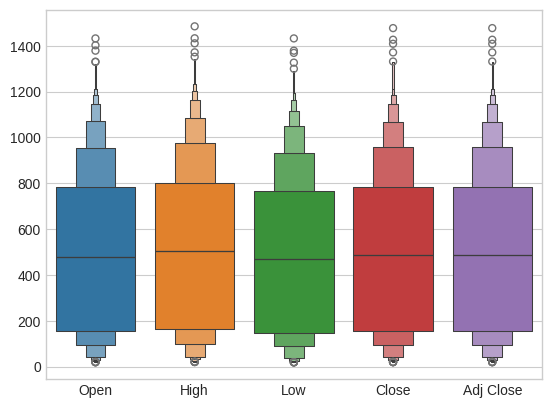

In [ ]:
del df['Volume']
sns.boxenplot(df)

In [ ]:
df = df[['Date', 'Close']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1218 entries, 0 to 1226
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1218 non-null   object 
 1   Close   1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.5+ KB


In [ ]:
df['Date'].min(), df['Date'].max()

('1997-06-30', '2020-12-28')

In [ ]:
pd.plotting.lag_plot(df['Close'])

## Visualize the Data

In [ ]:
fig = px.line(df.reset_index(), x='Date', y='Close', title='BIST 100 Inc. Stock Price 1997-2020')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Preprocess the Data

#### 1. Split the data

In [ ]:
train_size = int(len(df) * 0.90)
test_size = len(df) - train_size
train, test = df.loc[0:train_size], df.loc[train_size:len(df)]
train.shape, test.shape

((1088, 2), (123, 2))

#### 2. Scale the data

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))
train = train.copy()
test = test.copy()
train.loc[:, 'Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test.loc[:, 'Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

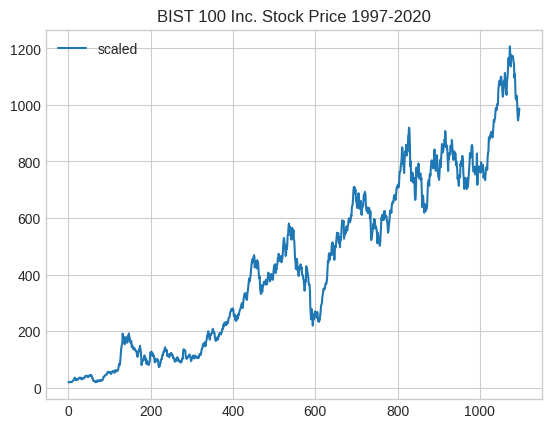

In [ ]:
plt.plot(train['Close'], label = 'scaled')
plt.title('BIST 100 Inc. Stock Price 1997-2020')
plt.legend()
plt.show()

#### 3. Create sequences

In [ ]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

In [ ]:
X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (1058, 30, 1)
Testing input shape:  (93, 30, 1)


## Build a Model

In [ ]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 30, 128)           0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 1)             129       
 stributed)                                           

## Train the Model

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/10
30/30 [==============================] - 8s 107ms/step - loss: 217797.4219 - val_loss: 912881.6875
Epoch 2/10
30/30 [==============================] - 2s 81ms/step - loss: 212852.2344 - val_loss: 905027.1875
Epoch 3/10
30/30 [==============================] - 2s 79ms/step - loss: 210077.5156 - val_loss: 898309.6875
Epoch 4/10
30/30 [==============================] - 3s 101ms/step - loss: 207490.9688 - val_loss: 891967.9375
Epoch 5/10
30/30 [==============================] - 5s 146ms/step - loss: 205051.7812 - val_loss: 885842.8750
Epoch 6/10
30/30 [==============================] - 5s 156ms/step - loss: 202667.7969 - val_loss: 879858.0625
Epoch 7/10
30/30 [==============================] - 6s 194ms/step - loss: 200369.1250 - val_loss: 873993.7500
Epoch 8/10
30/30 [==============================] - 5s 156ms/step - loss: 198109.0625 - val_loss: 868226.4375
Epoch 9/10
30/30 [==============================] - 6s 201ms/step - loss: 195890.7969 - val_loss: 862538.5625
Epoch 10/10


#### Training and Validation Loss

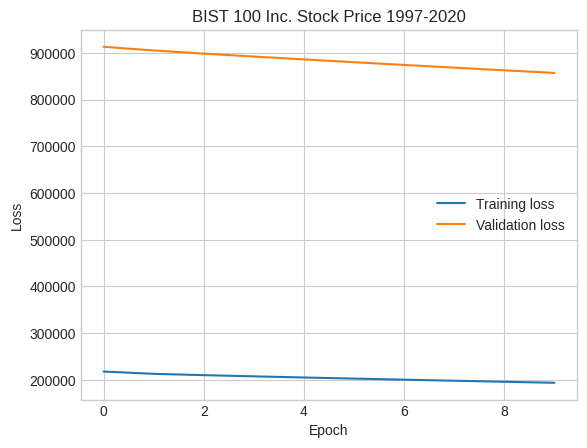

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("BIST 100 Inc. Stock Price 1997-2020")
plt.legend()
plt.show()

#### Mean Absolute Error Loss

34/34 [==============================] - 2s 24ms/step
Reconstruction error threshold: 967.2487356867799


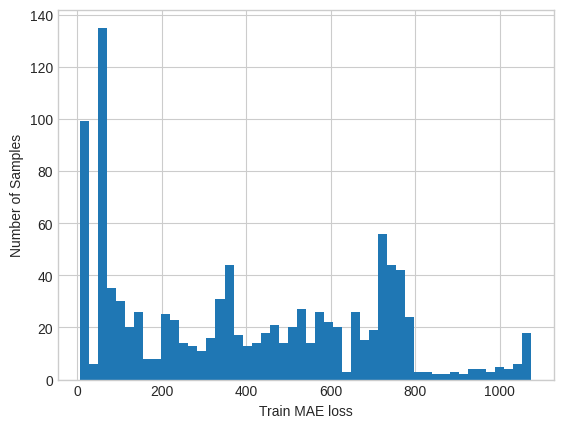

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss) * 0.9
print('Reconstruction error threshold:',threshold)

## Predict Anomalies

3/3 [==============================] - 0s 31ms/step


Text(0, 0.5, 'Number of samples')

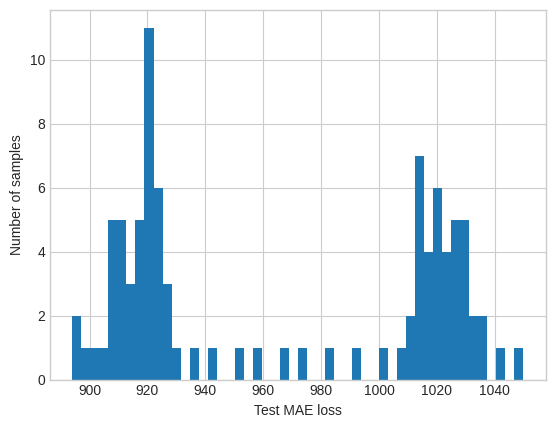

In [ ]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [ ]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [ ]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
1126,2019-01-28,1029.371016,894.060882,967.248736,False
1127,2019-02-04,1024.517031,895.461950,967.248736,False
1128,2019-02-11,1027.150000,899.646617,967.248736,False
1129,2019-02-18,1031.857031,902.524184,967.248736,False
1130,2019-02-25,1032.666016,905.057820,967.248736,False


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
1175,2020-01-06,1186.637031,973.075421,967.248736,True
1176,2020-01-13,1214.747969,982.367656,967.248736,True
1177,2020-01-20,1221.417969,991.518489,967.248736,True
1178,2020-01-27,1191.401016,1000.070656,967.248736,True
1179,2020-02-03,1210.151016,1006.572424,967.248736,True


In [ ]:
anomalies.shape

(44, 5)

In [ ]:
if anomalies.shape[0]:
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close'].values.reshape(-1, 1)).flatten(), name='Close price'))
  fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close'].values.reshape(-1, 1)).flatten(), mode='markers', name='Anomaly'))
  fig.update_layout(showlegend=True, title='Detected anomalies')
  fig.show()

### Anomaly Detection with Library

In [ ]:
!pip install adtk
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import PersistAD

In [ ]:
data = pd.read_csv('XU100.IS2.csv')

data = data.dropna()
data.loc[:1203, 'Open'] = data.loc[:1203, 'Open'] / 100
data.loc[:1203, 'High'] = data.loc[:1203, 'High'] / 100
data.loc[:1203, 'Low'] = data.loc[:1203, 'Low'] / 100
data.loc[:1203, 'Close'] = data.loc[:1203, 'Close'] / 100
data.loc[:1203, 'Adj Close'] = data.loc[:1203, 'Adj Close'] / 100
data = data.loc[data['Date'] < '2020-12-31']

open_data = data[['Date','Open']]
open_data = open_data.set_index('Date')
open_data.index = pd.to_datetime(open_data.index)
open_data

,Open
Date,
1997-06-30,18.570000
1997-07-07,19.180000
1997-07-14,20.270000
1997-07-21,20.100000
1997-07-28,18.890000
...,...
2020-11-30,1314.400024
2020-12-07,1330.000000
2020-12-14,1378.199951


Text(0.5, 1.0, 'Negative Persist Anomaly Detector')

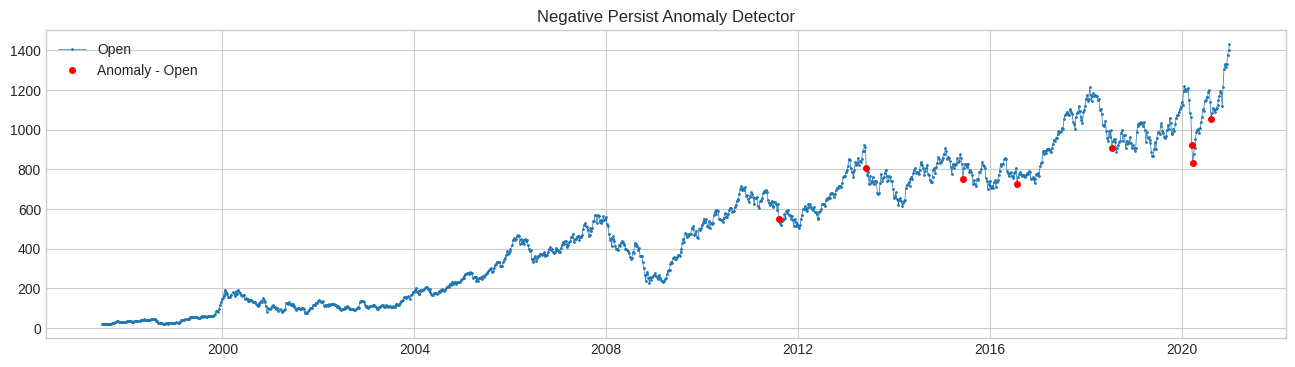

In [ ]:
persist_detector = PersistAD(c=3, side='negative')
anomalies = persist_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')
plt.title('Negative Persist Anomaly Detector')